In [1]:
from bs4 import BeautifulSoup
import requests
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

In [ ]:
all_dicts=[]
pages_left=[]

for year in [1940, 1941, 1942, 1943, 1944, 1945]:
    for start in range(0,50000,100):

        try:
            url=f'https://recherche-collection-search.bac-lac.gc.ca/eng/Home/Result?DataSource=Genealogy%7cMilitary%7cKia&DateBucket=1940-1949%7c{year}&SEARCH_TYPE=SEARCH_ADVANCED_HELP&num=100&start={start}&enviro=prod'
            html=requests.get(url,headers).content
            soup=BeautifulSoup(html)
        except:
            pages_left.append(url)
            continue

        records=soup.select('li[class="x"]')
        if len(records)==0:
            break

        for record in records:

            try:
                name=record.select_one('div[class="x"] h3').text.replace('\r','').replace('\n','').strip()
            except:
                name=None
            try:
                dob=record.select_one('dd[id*="x"]').text.replace('\r','').replace('\n','').strip()
            except:
                dob=None
            try:
                dod=record.select_one('dd[id*="x"]').text.replace('\r','').replace('\n','').strip()
            except:
                dod=None
            try:
                regiment=record.select_one('dd[id*="x"]').text.replace('\r','').replace('\n','').strip()
            except:
                regiment=None

            record_dict={'Name':name, 'DOB':dob, "DOD":dod, 'Regiment':regiment}
            all_dicts.append(record_dict)

        print(f'{year}-{start}-{len(all_dicts)}',end='\r')


In [5]:
import pandas as pd

df=pd.DataFrame(all_dicts)

In [ ]:
#df.to_csv('WW2_Canadian_Casualties.csv',index=False)

In [52]:
df=pd.read_csv('WW2_Canadian_Casualties.csv')

df

,Name,DOB,DOD,Regiment
0,"ALLAN, FRANK",1901-04-02,1940-10-10,Royal Canadian Army Service Corps
1,"ALLARDYCE, LANCELOT MATTHEW",1904-05-23,1940-10-10,"Calgary Highlanders, R.C.I.C."
2,"ALLEN, LAWRENCE HENRY",1912-02-25,1940-07-17,"Loyal Edmonton Regiment, R.C.I.C."
3,"ARMITAGE, MAXWELL JAMES",1917-04-01,1940-07-15,Royal Canadian Air Force
4,"AREND, HUBERT ALOYSE",1900-07-31,1940-12-26,Royal Canadian Air Force
...,...,...,...,...
42734,"SIMS, FREDERICK JAMES",1921,1945-04-14,Royal Canadian Regiment
42735,"WALMSLEY, RAYMOND",NaN,1945-04-11,"British Columbia Regiment, R.C.A.C."
42736,"WILSON, GEORGE THOMAS",1921,1945-04-06,"12th Manitoba Dragoons, R.C.A.C."
42737,"WILSON, JOHN HOWARD",1925-06-22,1945-04-14,"Royal Regiment of Canada, R.C.I.C."


In [53]:
df['DOB']=pd.to_datetime(df['DOB'].apply(lambda x : f'{x}-01-01' if isinstance(x,str) and '-' not in x else x), errors='coerce')

In [54]:
df['DOD']=pd.to_datetime(df['DOD'])

In [55]:
df['Age']=(df['DOD']-df['DOB']).dt.days//365

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

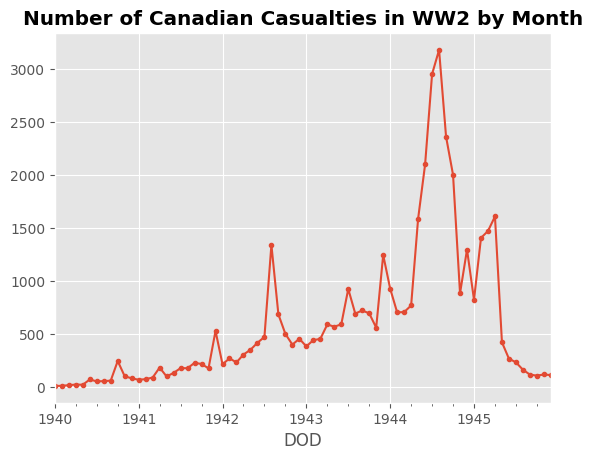

In [75]:
grouped=df.groupby(df['DOD'].dt.to_period('M'))['Name'].count().sort_index()

grouped.plot.line(marker='.')
plt.title('Number of Canadian Casualties in WW2 by Month',fontweight='bold')
plt.show()

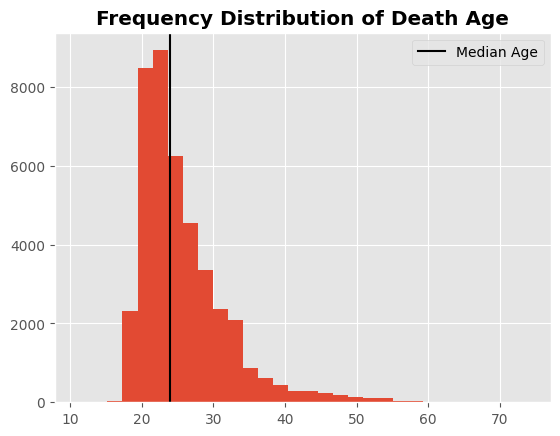

In [72]:
median_age=df['Age'].median()


df['Age'].hist(bins=30)
plt.title('Frequency Distribution of Death Age',fontweight='bold')
plt.axvline(median_age,color='black',label='Median Age')
plt.legend()
plt.show()

In [119]:
grouped=df['Regiment'].value_counts(normalize=True)

regiment_dict={}
other_value=0
for i, v in zip(grouped.index, grouped.values):
    if v>0.01:
        regiment_dict[i]=v

    else:
        other_value+=v

regiment_dict['Other']=other_value

grouped = pd.DataFrame(list(regiment_dict.items()), columns=['Regiment', 'Share']).set_index('Regiment')

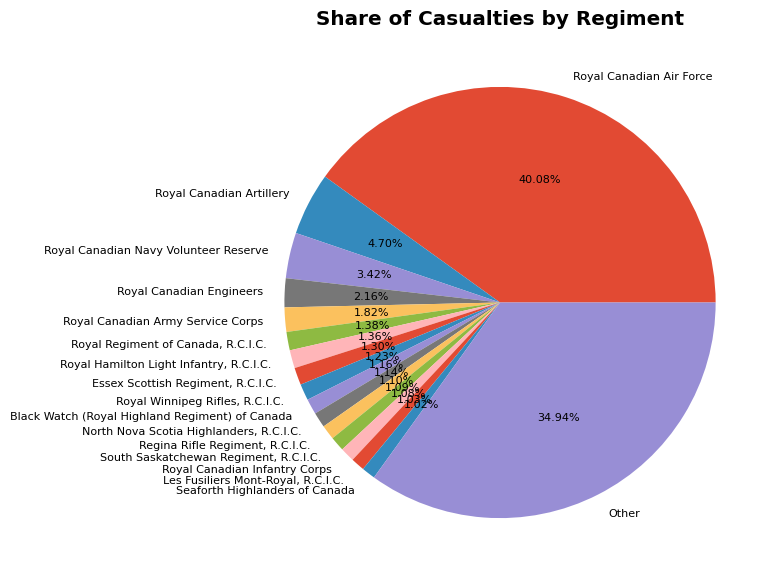

In [129]:
grouped.plot.pie(y='Share', legend=False, autopct='%0.2f%%',figsize=(7,7),fontsize=8,label='')
plt.title('Share of Casualties by Regiment',fontweight='bold')
plt.show()